In [1]:
import warnings
warnings.filterwarnings("ignore")
import json
import os
import random
import torch
import tqdm
from PIL import Image
from pathlib import Path
from collections import defaultdict
import sys
sys.path[0] = os.path.abspath('..')
import torchvision.transforms as transforms
import argparse
from torchvision.transforms.functional import InterpolationMode
from extras_ import convert_sents_to_features, BertLayer
from finetune import ContextualBLIP
from models.contextual_new import Adapter_BLIP
from volta_src.config import BertConfig
import yaml
import torch.nn as nn
from utils import pre_caption

parser = argparse.ArgumentParser()
parser.add_argument('--valid_descr_path', type=str, default='dataset/valid_data.json')
parser.add_argument('--train_descr_path', type=str, default='dataset/train_data.json')
parser.add_argument('--imgs_path', type=str, default='dataset/image-sets')
parser.add_argument("--add_input", action="store_true",default=True)
parser.add_argument("--positional", action="store_true",default=True)
parser.add_argument("--transformer_layers", default=2, type=int)
parser.add_argument("--all_pos", action="store_true",default=False)
parser.add_argument("-a", "--activation", default='relu')
parser.add_argument("-s", "--logit_scale", default=1000)
parser.add_argument("--frozen_blip", action="store_true",default=True)
args = parser.parse_args([])

In [15]:
# IMAGECODE
img_dirs = args.imgs_path
valid_data = json.load(open(args.valid_descr_path, 'r'))
valid = []
for img_dir, data in valid_data.items():
    for img_idx, text in data.items():
        valid.append((img_dir, img_idx, text))
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'DEVICE USED: {device}')

DEVICE USED: cuda


In [3]:
# 模型路径
blip_model_path = 'checkpoints/1/blip_finetuned_model.pt'
adater_blip_model_path = '4_0.25_36_0.3493_18.pt'

bert_config = json.load(open('vilbert-and-bert-config.json', 'r'))

adater_blip = ContextualBLIP(bert_config, args,pretrain=False).cuda()
checkpoint = torch.load(adater_blip_model_path)
adater_blip.load_state_dict(checkpoint['model_state_dict'],strict= False)

blip = ContextualBLIP(bert_config, args,pretrain=False).cuda()
checkpoint = torch.load(blip_model_path)
blip.load_state_dict(checkpoint['model_state_dict'],strict= False)

adater_blip.cuda()
adater_blip.eval()
blip.cuda()
blip.eval()

preprocess = transforms.Compose([
    transforms.Resize((224,224),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ]) 

tf params: 14175744
tf params: 14175744


In [4]:
def find_by_text(dataset, text):
    for img_dir, img_idx, t in tqdm.tqdm(dataset):
        if text == t:
            return img_dir,img_idx,text
    return False

In [23]:
caption = 'the transition image into the one of the lady in blue from the one where bags where hang up'
caption2 = 'There is picture overlay with the first picture having slightly more visibility than the second. '

In [21]:
caption2

'There is picture overlay with the first picture having slightly more visibility than the second.'

 42%|████▏     | 958/2302 [00:00<00:00, 935321.98it/s]


  0%|          | 0/2302 [00:00<?, ?it/s]


4
ground truth: 4 blip: 5 ours: 4
There is picture overlay with the first picture having slightly more visibility than the second. 
tensor([[[-0.7014],
         [-0.3967],
         [-0.2379],
         [ 0.5918],
         [ 0.7292],
         [ 0.4218],
         [ 0.0473],
         [-0.0960],
         [-1.1633],
         [-1.7313]]], device='cuda:0')


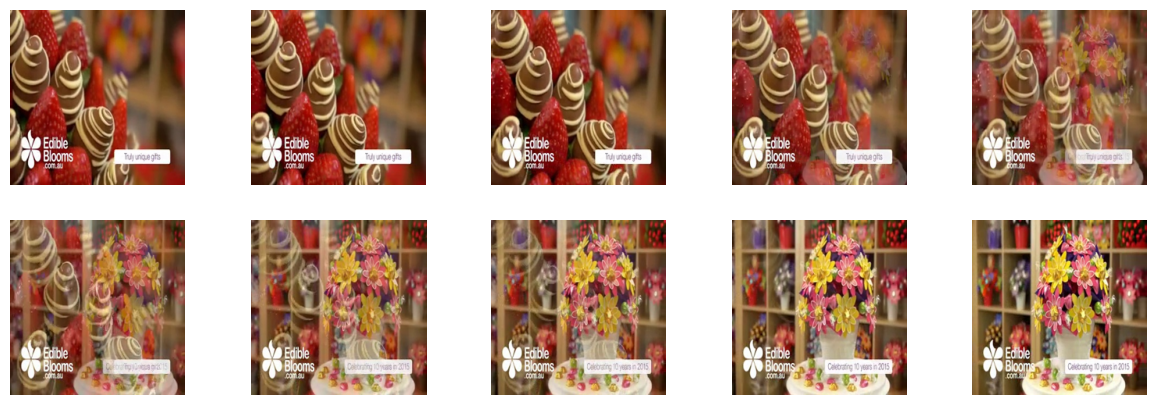

In [25]:
random.shuffle(valid)
with torch.no_grad():
    for img_dir, img_idx, text_ in tqdm.tqdm(valid):
        img_dir, img_idx, text_ = find_by_text(valid,caption2)

        text = [pre_caption(text_)]
        img_idx = int(img_idx)
        img_files = list((Path(img_dirs) / img_dir).glob("*.jpg"))
        img_files = sorted(img_files, key=lambda x: int(str(x).split('/')[-1].split('.')[0][3:]))
        images = [Image.open(photo_file).convert("RGB") for photo_file in img_files]
        preprocess = transforms.Compose([
            transforms.Resize((224,224),interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
            ])  
        images = [preprocess(image) for image in images]
        image = torch.stack(images).to(device)
        
        if "open-images" in str(img_dir):
            pos_mask = torch.zeros((10, 1)).cuda()
        else:
            pos_mask = torch.ones((10, 1)).cuda()
        print(img_idx)
        break

from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(2,5,figsize=(15,5))

images = [Image.open(photo_file).convert("RGB").resize((224,224)) for photo_file in img_files]
for i,img in enumerate(images):
    ax[i//5,i%5].imshow(np.array(img))
    ax[i//5,i%5].axis('off')
fig.show()

with torch.no_grad():
    logits,attn1 = blip(image, text,pos_mask,output_attn=True)
    pred1 = torch.argmax(logits.squeeze()).squeeze()
    logits,attn2 = adater_blip(image, text,pos_mask,output_attn=True)
    pred2 = torch.argmax(logits.squeeze()).squeeze()
    print("ground truth:",img_idx,"blip:",pred1.cpu().item(),'ours:',pred2.cpu().item())
    print(text_)
    print(logits)
    

### Case Study 想法
上面的文本存在几个判断条件，分别为"the lady in blue"、"bags were hang up"和"the transition image"
通过模型输出各图的logits，我们可以体现模型是否真正关注到这些判定信息
下面分别用三个子条件的文本进行检索，可以看到除了"the lady in blue"效果不好，另两个效果都很不错

In [31]:
subcaption1 = "the lady in blue"
subcaption2 = "bags were hang up"
subcaption3 = "the transition image"
subcaption4 = "the first picture"
subcaption5 = "the second picture"

In [32]:
with torch.no_grad():
    text = [pre_caption(subcaption4)]
    logits,attn2 = adater_blip(image, text,pos_mask,output_attn=True)
    pred2 = torch.argmax(logits.squeeze()).squeeze()
    print("ground truth:",img_idx,'ours:',pred2.cpu().item())
    print(text)
    print(logits)

ground truth: 4 ours: 2
['the first picture']
tensor([[[-0.5236],
         [-0.1701],
         [ 0.1392],
         [-0.0532],
         [-0.0054],
         [-0.1161],
         [-0.1939],
         [-0.2789],
         [-0.8129],
         [-1.1268]]], device='cuda:0')


In [33]:
with torch.no_grad():
    text = [pre_caption(subcaption5)]
    logits,attn2 = adater_blip(image, text,pos_mask,output_attn=True)
    pred2 = torch.argmax(logits.squeeze()).squeeze()
    print("ground truth:",img_idx,'ours:',pred2.cpu().item())
    print(text)
    print(logits)

ground truth: 4 ours: 4
['the second picture']
tensor([[[-0.6393],
         [-0.3087],
         [ 0.0425],
         [-0.0776],
         [ 0.0568],
         [-0.0726],
         [-0.1462],
         [-0.2790],
         [-0.8249],
         [-1.1681]]], device='cuda:0')


In [11]:
with torch.no_grad():
    text = [pre_caption(subcaption3)]
    logits,attn2 = adater_blip(image, text,pos_mask,output_attn=True)
    pred2 = torch.argmax(logits.squeeze()).squeeze()
    print("ground truth:",img_idx,'ours:',pred2.cpu().item())
    print(text)
    print(logits)

ground truth: 7 ours: 3
['the transition image']
tensor([[[-0.4953],
         [-1.2187],
         [-0.6336],
         [ 0.2247],
         [-0.0771],
         [-0.1447],
         [-0.3642],
         [ 0.0388],
         [-1.0809],
         [-1.7553]]], device='cuda:0')
